In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.config.run_functions_eagerly(True)

## Fashion MNIST DNN 분류기 구현하기
  
### Fashion MNIST란?
https://www.tensorflow.org/datasets/catalog/fashion_mnist

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
tfds.list_builders()[70:80]

['fashion_mnist',
 'flic',
 'flores',
 'food101',
 'forest_fires',
 'fuss',
 'gap',
 'geirhos_conflict_stimuli',
 'genomics_ood',
 'german_credit_numeric']

In [ ]:
dataset, info = tfds.load('fashion_mnist',
                          split=["train","test"],
                          with_info=True,
                          shuffle_files=True,
                          as_supervised=True)

In [ ]:
dataset

[<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>]

In [ ]:
# tfds에서 제공하는 data의 정보를 보여줍니다.
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

|Label|	Description|
|---|---|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|


In [ ]:
train_data, test_data = dataset

In [ ]:
# 데이터의 개수를 카운트하는 함수.
def count_datasets(dataset):
    cnt = [x for x, y in enumerate(dataset)][-1] + 1
    return cnt

count_datasets(test_data)

10000

In [ ]:
tmp = train_data.take(1)
list(tmp.as_numpy_iterator())

Class : 2


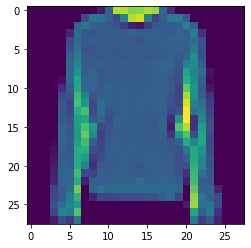

In [ ]:
# 데이터 하나를 뽑아서 출력해봅니다.
for image, label in train_data.take(1):
    plt.imshow(image[:,:,0])
    print(f"Class : {label.numpy()}")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


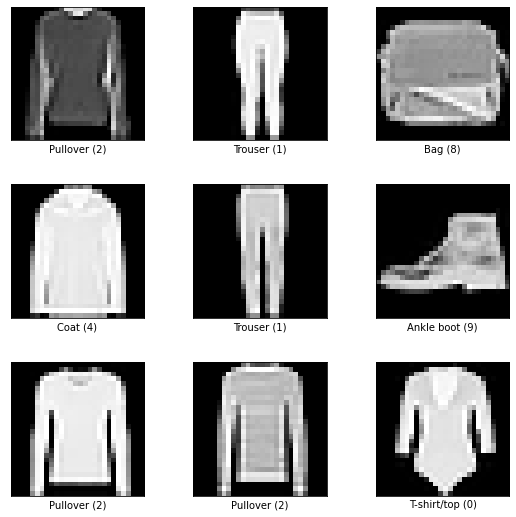

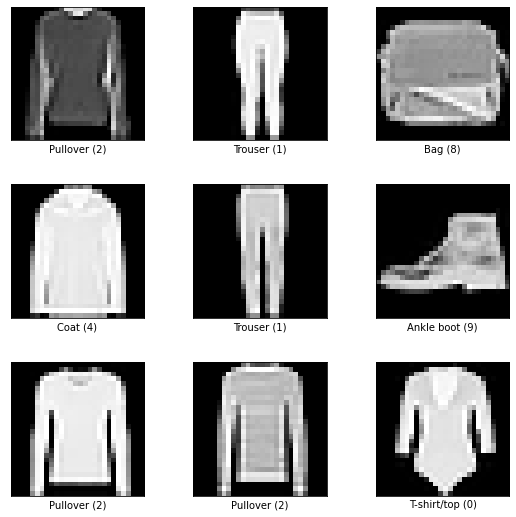

In [ ]:
# tfds의 내부 메소드로 샘플 이미지들을 보여줍니다.
tfds.show_examples(train_data, info)

In [ ]:
# hyperparamter와 arguments
TRAIN_SIZE = info.splits['train'].num_examples // 64
BATCH_SIZE = 64
EPOCHS = 10

### 데이터 정규화

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    
    # tf.cast로 텐서의 데이터 타입을 바꿔줍니다.
    return tf.cast(image, tf.float32) / 255., label

`tf.data.Dataset.map`에 `num_parallel_calls`는 cpu 코어들의 병렬 처리를 하도록 합니다.  
데이터는 서로 독립적이기 때문에 병렬 처리가 가능합니다.  
`tf.data.experimental.AUTOTUNE`로 자동으로 코어를 잡아줍니다.

In [ ]:
train_data = train_data.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_data = train_data.cache()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


### 학습 데이터 준비
학습을 위해 데이터셋을 셔플링하고 배치단위로 나누어 주겠습니다.

In [ ]:
# 데이터 셋의 순서를 섞어줍니다.
train_data = train_data.shuffle(buffer_size=info.splits['train'].num_examples)

In [ ]:
train_data = train_data.repeat()

In [ ]:
# 배치 단위로 나누어 줍니다.
train_data = train_data.batch(batch_size=BATCH_SIZE)

In [ ]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(64).prefetch(tf.data.AUTOTUNE)

In [ ]:
for i in range(3):
    _, label = next(iter(train_data))
    print(label)

tf.Tensor(
[5 8 0 8 7 7 6 0 9 3 8 7 6 2 4 0 1 2 9 0 4 1 9 2 1 7 3 6 6 1 2 4 2 2 4 4 9
 7 6 8 6 9 0 6 5 5 0 6 8 4 4 9 5 4 7 4 9 5 4 3 5 9 5 9], shape=(64,), dtype=int64)
tf.Tensor(
[9 1 9 8 5 5 8 8 5 5 6 0 2 2 5 4 5 7 1 2 0 7 6 7 4 1 9 3 8 5 8 9 0 8 9 3 6
 8 4 1 2 6 9 9 7 9 8 1 9 4 3 5 7 9 7 3 7 9 2 9 3 6 1 6], shape=(64,), dtype=int64)
tf.Tensor(
[1 9 0 2 1 4 3 7 2 5 1 6 4 7 1 2 2 6 5 4 2 0 1 7 9 3 9 4 3 0 6 7 1 1 6 1 5
 0 7 1 9 3 9 5 9 8 8 8 0 0 1 4 7 3 7 2 9 8 8 2 4 3 6 6], shape=(64,), dtype=int64)


### DNN 모델 구현하기

In [ ]:
DNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

DNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 136,074
Trainable params: 136,074
Non-trainable params: 0
__________________________________________________

### CNN 모델 구현하기

In [ ]:
class CNN_model(tf.keras.Model):
    def __init__(self, num_classes, hidden_dim):
        super(CNN_model, self).__init__()
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        self.fc_block = tf.keras.Sequential([
                                             tf.keras.layers.Flatten(),
                                             tf.keras.layers.Dense(512),
                                             tf.keras.layers.Dense(512),
                                             tf.keras.layers.Dense(self.num_classes,
                                                                   activation='softmax')
        ])

        self.conv_block0 = ConvBlock(filters=hidden_dim[0])
        self.conv_block1 = ConvBlock(filters=hidden_dim[1])
        self.conv_block2 = ConvBlock(filters=hidden_dim[2])
        self.conv_block3 = ConvBlock(filters=hidden_dim[3])
    
    def call(self, inputs):
        x = self.conv_block0(inputs)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        out = self.fc_block(x)
        return out

class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()

        self.filters = filters
        self.conv1 = tf.keras.layers.Conv2D(filters=self.filters,
                                            kernel_size=3,
                                            padding='same')
        self.BN1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=self.filters,
                                            kernel_size=3,
                                            padding='same')
        self.BN2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=self.filters,
                                            kernel_size=3,
                                            padding='same')
        self.BN3 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.pool = tf.keras.layers.MaxPool2D((2,2),2)
    
    def call(self, input):
        x = self.conv1(input)
        x = self.BN1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.BN2(x)
        x = self.relu(x)
        if self.filters == 512:
            x = self.conv3(x)
            x = self.BN3(x)
            x = self.relu(x)
        return self.pool(x)

In [ ]:
HIDDEN_DIM = [64, 128, 256, 512]
cnn_model = CNN_model(num_classes=10,
                      hidden_dim=HIDDEN_DIM)

In [ ]:
input = tf.keras.layers.Input((28,28,1))
cnn_model(input)

<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'cnn_model')>

In [ ]:
cnn_model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 10)                530442    
_________________________________________________________________
conv_block (ConvBlock)       multiple                  38080     
_________________________________________________________________
conv_block_1 (ConvBlock)     multiple                  222464    
_________________________________________________________________
conv_block_2 (ConvBlock)     multiple                  887296    
_________________________________________________________________
conv_block_3 (ConvBlock)     multiple                  5905920   
Total params: 7,584,202
Trainable params: 7,579,338
Non-trainable params: 4,864
_________________________________________________________________


### Model Training

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### DNN model training

In [ ]:
(train_x, train_y)

In [ ]:
DNN_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

dnn_history = DNN_model.fit(train_data,
                        epochs=EPOCHS,
                        validation_data=test_data,
                        verbose=1,
                        steps_per_epoch=TRAIN_SIZE)

Epoch 1/10
937/937 [==============================] - 14s 15ms/step - loss: 0.5603 - accuracy: 0.8002 - val_loss: 0.4108 - val_accuracy: 0.8514
Epoch 2/10
937/937 [==============================] - 13s 14ms/step - loss: 0.4126 - accuracy: 0.8493 - val_loss: 0.3857 - val_accuracy: 0.8619
Epoch 3/10
937/937 [==============================] - 13s 14ms/step - loss: 0.3765 - accuracy: 0.8626 - val_loss: 0.3860 - val_accuracy: 0.8581
Epoch 4/10
937/937 [==============================] - 14s 14ms/step - loss: 0.3558 - accuracy: 0.8685 - val_loss: 0.3615 - val_accuracy: 0.8675
Epoch 5/10
937/937 [==============================] - 14s 15ms/step - loss: 0.3373 - accuracy: 0.8755 - val_loss: 0.3452 - val_accuracy: 0.8741
Epoch 6/10
937/937 [==============================] - 14s 15ms/step - loss: 0.3244 - accuracy: 0.8787 - val_loss: 0.3409 - val_accuracy: 0.8766
Epoch 7/10
937/937 [==============================] - 13s 14ms/step - loss: 0.3140 - accuracy: 0.8832 - val_loss: 0.3673 - val_accuracy:

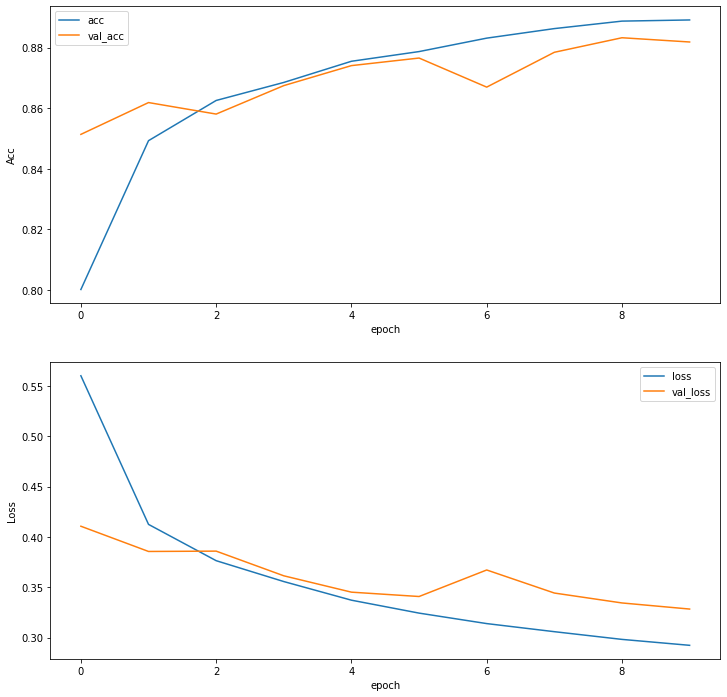

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(211)
plt.plot(dnn_history.history['accuracy'], label='acc')
plt.plot(dnn_history.history['val_accuracy'], label='val_acc')
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.legend()

plt.subplot(212)
plt.plot(dnn_history.history['loss'], label='loss')
plt.plot(dnn_history.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### Dnn model Test

In [ ]:
DNN_model.evaluate(test_data)

157/157 [==============================] - 1s 9ms/step - loss: 0.3285 - accuracy: 0.8819


[0.328456312417984, 0.8819000124931335]

In [ ]:
image, label = next(iter(test_data))
sample_img, sample_label = image[0], label[0]

4


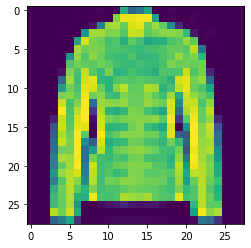

In [ ]:
plt.imshow(sample_img[:,:,0])
print(sample_label.numpy())

In [ ]:
sample_img = sample_img[np.newaxis,:,:,:]
y_hat = DNN_model.predict(sample_img)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
pred = np.argmax(y_hat, axis=-1)
pred

array([4])

#### CNN model training

In [ ]:
epochs = EPOCHS

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
cnn_history = cnn_model.fit(
    train_data, epochs=EPOCHS, validation_data=test_data, steps_per_epoch=TRAIN_SIZE
)

Epoch 1/10
937/937 [==============================] - 73s 44ms/step - loss: 0.4946 - accuracy: 0.8306 - val_loss: 0.3368 - val_accuracy: 0.8793
Epoch 2/10
937/937 [==============================] - 44s 47ms/step - loss: 0.2817 - accuracy: 0.9007 - val_loss: 0.2620 - val_accuracy: 0.9065
Epoch 3/10
937/937 [==============================] - 42s 44ms/step - loss: 0.2399 - accuracy: 0.9143 - val_loss: 0.2678 - val_accuracy: 0.9062
Epoch 4/10
937/937 [==============================] - 41s 44ms/step - loss: 0.2060 - accuracy: 0.9267 - val_loss: 0.3327 - val_accuracy: 0.8836
Epoch 5/10
937/937 [==============================] - 41s 44ms/step - loss: 0.5860 - accuracy: 0.8471 - val_loss: 0.4439 - val_accuracy: 0.8428
Epoch 6/10
937/937 [==============================] - 42s 44ms/step - loss: 0.3107 - accuracy: 0.8905 - val_loss: 0.2941 - val_accuracy: 0.8920
Epoch 7/10
937/937 [==============================] - 41s 43ms/step - loss: 0.2111 - accuracy: 0.9246 - val_loss: 0.2253 - val_accuracy:

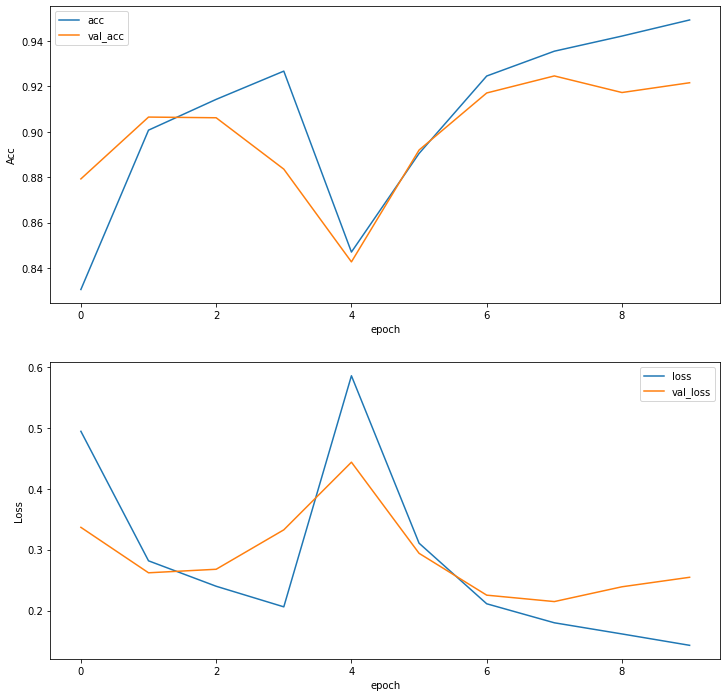

In [ ]:
plt.figure(figsize=(12,12))

plt.subplot(211)
plt.plot(cnn_history.history['accuracy'], label='acc')
plt.plot(cnn_history.history['val_accuracy'], label='val_acc')
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.legend()

plt.subplot(212)
plt.plot(cnn_history.history['loss'], label='loss')
plt.plot(cnn_history.history['val_loss'], label='val_loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

#### CNN model test

In [ ]:
cnn_model.evaluate(test_data)

157/157 [==============================] - 3s 20ms/step - loss: 0.2546 - accuracy: 0.9216


[0.2546447813510895, 0.9215999841690063]

In [ ]:
image, label = next(iter(test_data))
sample_img, sample_label = image[0], label[0]

4


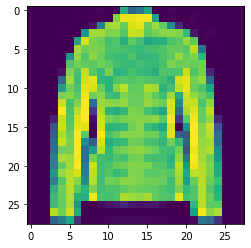

In [ ]:
plt.imshow(sample_img[:,:,0])
print(sample_label.numpy())

In [ ]:
sample_img = sample_img[np.newaxis,:,:,:]
y_hat = cnn_model.predict(sample_img)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
pred = np.argmax(y_hat, axis=-1)
pred

array([4])